# Credit Card Fraud Detection

The use of credit cards for online purchases is increasing every day. All of these operations attract the attention of some people who wish to hack and steal credit card information for fraud purposes.
Therefore, it is absolutely important that banks understand how fraudulent transactions work and how they can be identified, as such fraud represents a cost to the bank and damages both the bank and the customers.
Machine learning proves to be a very interesting tool to identify these fraudulent transactions, especially when fraud methods become more and more ingenious. This notebook it is intended to test and analyze machine learning models for the identification of fraudulent transactions within a scenario where the data presents a very large imbalance, some solutions for such imbalance will be worked to assist such models.

### Main challenges involved in credit card fraud detection:
 * Immense data is processed every day and a model built should be fast enough to respond the scan time.
 * Imbalanced data: Most of transactions (99.8%) are not fraudulent making the fraud detection process difficult.
 * Private data: that fact imply in most of the time working with some kind of transformed data like PCA.
 * Misclassified data could be a potential issue for the problem, model and banks.
 
### How to tackle these challenges?
 * A simple and fast model to be responsive and accurate
 * Imbalanced data can be solved using sampling techniques or
 * Interpretive model to understand better the fraudulent nuances

## 1. Imports

In [2]:
#Warning supress in case that sklearn models return the warning of maximun interation.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
%pip install imblearn
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, SelectPercentile, RFE
from sklearn.utils import resample
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import NearMiss

### Data Importing and Checking

In [4]:
dataset = pd.read_csv('creditcard.csv')

In [5]:
dataset.isnull().values.any()
dataset.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


There are thirty-one variables present in the data, of which twnty-eight are projections of a PCA V1-V28, the others are Time, Amount, and Class. All features are numeric float and the problem consist in binary classification of fraudulent transactions.

## 2. Exploratory Data Analysis (EDA)

The main goal of exploratory data analysis is to find features that stand out and show interesting behaviors, such features that can facilitate the classification task, show bias, or assist in choosing which features should be used.

Initially the data will be separated into their respective classes and their distribution will be analyzed over time as well as the amounts.

In [18]:
frd = dataset[dataset["Class"] == 1]
nml = dataset[dataset["Class"] == 0]

outlierFraction = len(frd)/float(len(dataset))*100
print(outlierFraction,"% Fraud")
print('Fraud Cases: {}'.format(len(frd)))
print('Valid Transactions: {}'.format(len(nml)))

0.1727485630620034 % Fraud
Fraud Cases: 492
Valid Transactions: 284315


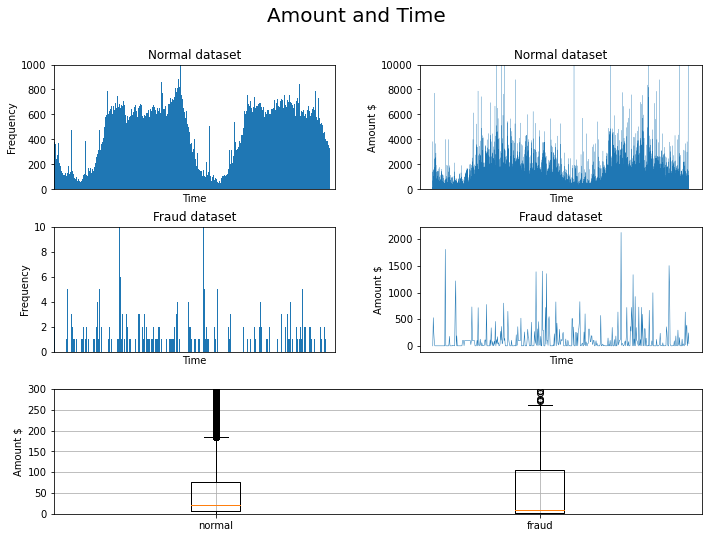

In [9]:
minn = int(min(dataset.Time.values))
maxx = int(max(dataset.Time.values))
bins = np.arange(minn,maxx,17)
lim = [minn, len(bins)+200]

all_p = np.digitize(dataset.Time.values, bins=bins)
frd_p = np.digitize(frd.Time.values, bins=bins)
nml_p = np.digitize(nml.Time.values, bins=bins)

fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(left=0.08, right=0.98, bottom=0.1, wspace=0.3, hspace=0.3)
plt.suptitle("Amount and Time", fontsize=20)

ax1 = plt.subplot2grid((3,2), (0,0))
ax2 = plt.subplot2grid((3,2), (0,1))
ax3 = plt.subplot2grid((3,2), (1,0))
ax4 = plt.subplot2grid((3,2), (1,1))
ax5 = plt.subplot2grid((3,2), (2,0), colspan=2)

ax1.hist(all_p, bins)
ax1.set_xticks([])
ax1.set_xlim(lim)
ax1.set_ylim(0,1000)
ax1.set_title('Normal dataset')
ax1.set_ylabel('Frequency')
ax1.set_xlabel("Time")


ax2.plot(nml.Time.values, nml.Amount.values, lw=0.2)
ax2.set_xticks([])
ax2.set_xlabel(range(0,200000,25000))
ax2.set_ylim(0,10000)
ax2.set_title('Normal dataset')
ax2.set_ylabel('Amount $')
ax2.set_xlabel('Time')

ax3.hist(frd_p, bins)
ax3.set_title("Fraud dataset")
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Time')
ax3.set_xticks([])
ax3.set_xlim(lim)
ax3.set_ylim([0,10])

ax4.plot(range(len(frd)), frd.Amount.values, linewidth=0.5)
ax4.set_title('Fraud dataset')
ax4.set_ylabel('Amount $')
ax4.set_xlabel('Time')
ax4.set_xticks([])

ax5.boxplot([nml.Amount.values, frd.Amount.values], labels=['normal', 'fraud'])
ax5.set_ylim(0,1000)
ax5.set_ylim([0,300])
ax5.grid('horizontal')
ax5.set_ylabel('Amount $')

plt.show()

It is possible to visualize that the fraudulent transactions mean are slightly lower than the normal transactions and the distribution over the time seems to be constant. The next step is to analyse the features V1-V28.

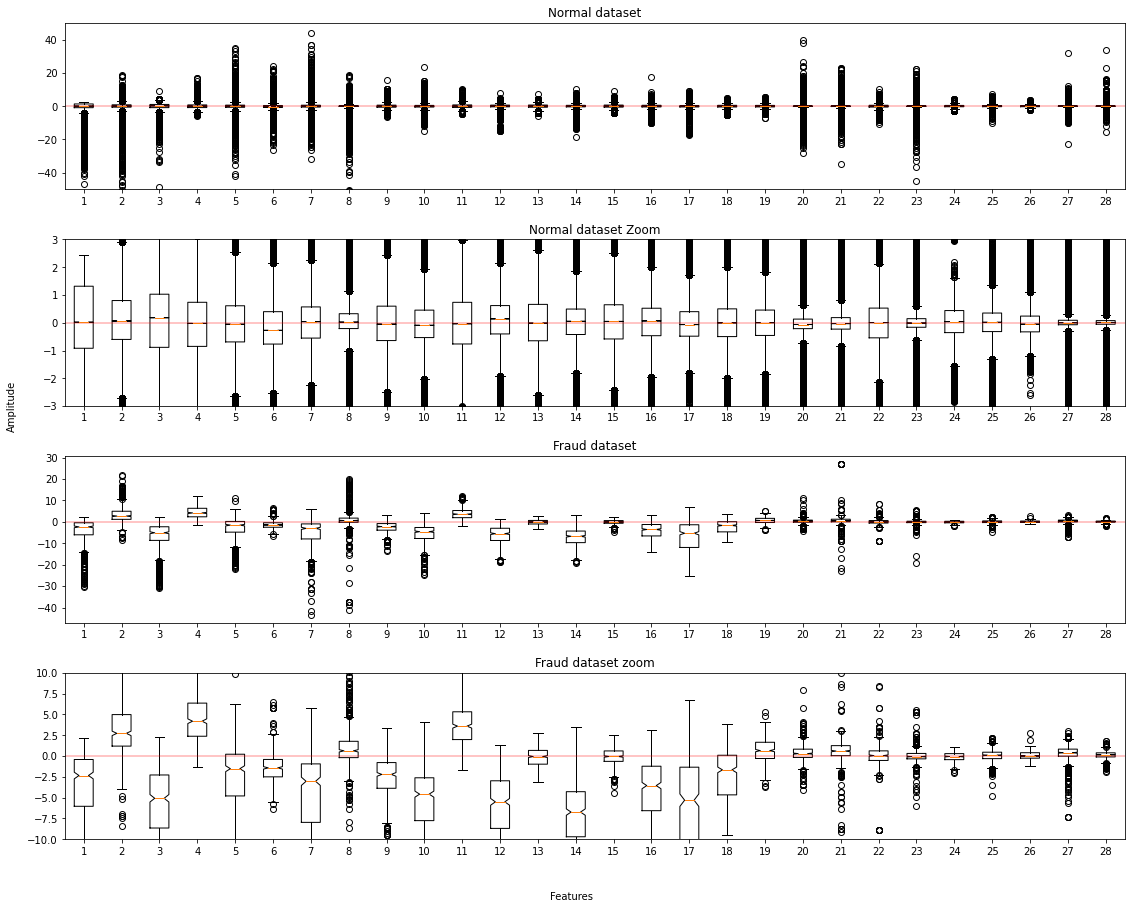

In [10]:
features = list(dataset.columns)[1:-2]
var1 = [nml[feature] for feature in features]
var2 = [frd[feature] for feature in features]
# var2 = [new[feature] for feature in features]

fig, ax = plt.subplots(4,1, figsize=(16,14))
plt.subplots_adjust(left=0.06, right=0.98, bottom=0.07, wspace=0.2, hspace=0.3)

ax[0].boxplot(var1, features)
ax[0].axhline(0, c='r', alpha=0.3)
ax[0].set_ylim((-50,50))
ax[0].title.set_text('Normal dataset')

ax[1].boxplot(var1, features)
ax[1].axhline(0, c='r', alpha=0.3)
ax[1].set_ylim((-3,3))
ax[1].title.set_text('Normal dataset Zoom')

ax[2].boxplot(var2, features)
ax[2].title.set_text('Fraud dataset')
ax[2].axhline(0, c='r', alpha=0.3)

ax[3].boxplot(var2, features)
ax[3].title.set_text('Fraud dataset zoom')
ax[3].axhline(0, c='r', alpha=0.3)
ax[3].set_ylim((-10,10))

fig.text(0.5, 0.01, 'Features', ha='center')
fig.text(0.01, 0.5, 'Amplitude', va='center', rotation='vertical')
plt.show()

As can see in the zoomed boxplots, fraudulent transactions show a distinct behavior and amplitudes for some features. It can be a point to explore in the futures selecting that features V1-V18 to train and test some models.Next step correlation matrix.

<AxesSubplot:title={'center':'Correlation Matrix Normal Transactions'}>

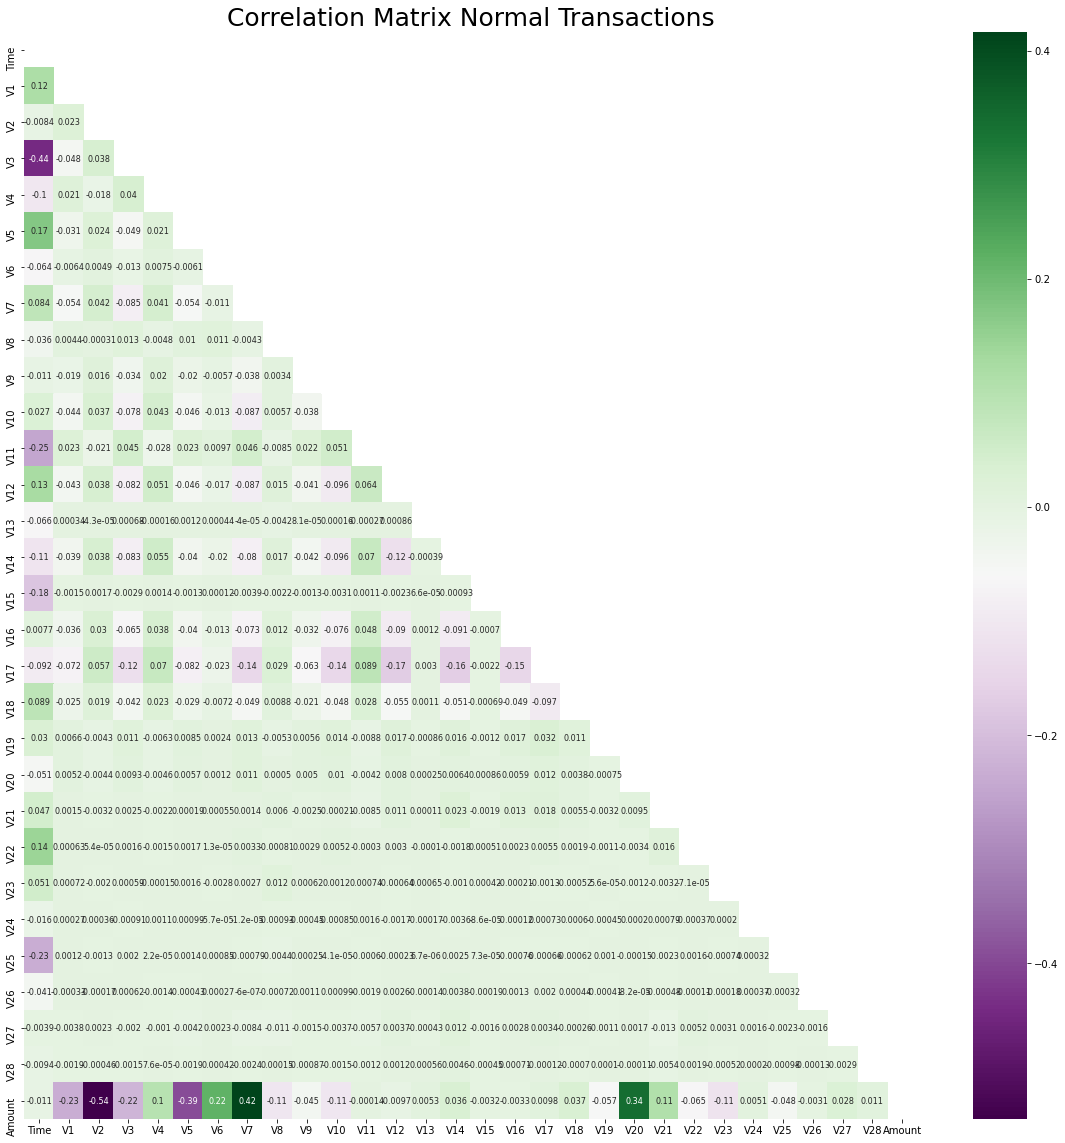

In [11]:
corr_matrix = nml.iloc[:,:-1].corr()
corr_features = corr_matrix.index

fig1 = plt.figure(figsize=(20,20))
plt.title('Correlation Matrix Normal Transactions', fontsize=25)
sb.heatmap(corr_matrix,annot=True,annot_kws={"size": 8},cmap="PRGn", mask=np.triu(corr_matrix))

<AxesSubplot:title={'center':'Correlation Matrix Fraud Transactions'}>

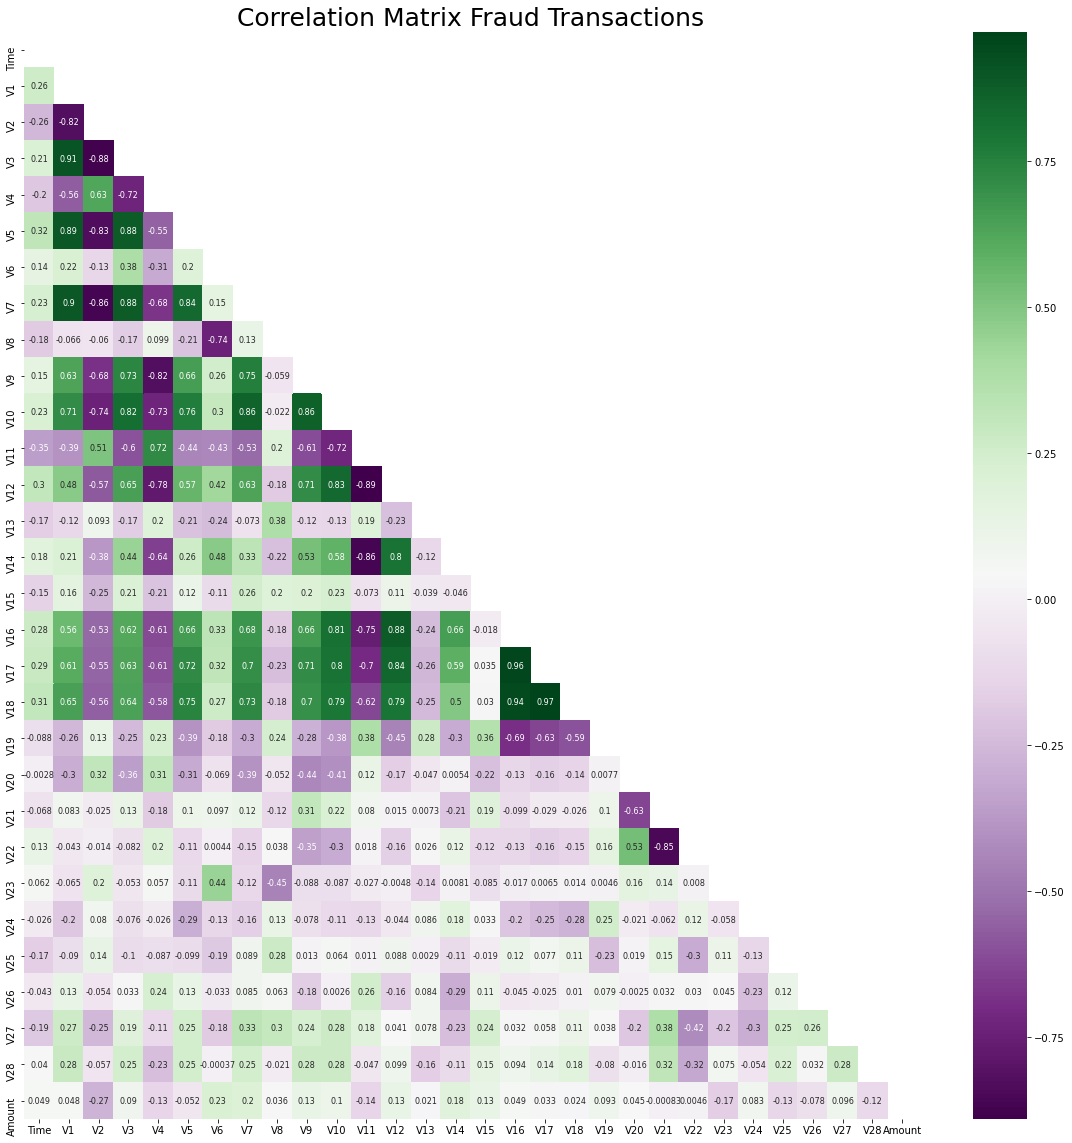

In [12]:
corr_matrix = frd.iloc[:,:-1].corr()
corr_features = corr_matrix.index

fig1 = plt.figure(figsize=(20,20))
plt.title('Correlation Matrix Fraud Transactions', fontsize=25)
sb.heatmap(corr_matrix,annot=True,annot_kws={"size": 8},cmap="PRGn", mask=np.triu(corr_matrix))

Both classes separeted early are now analyzed by their correlation matrix.
* Most features of normal transactions are not correlated exept V6,V7 and V20 that seems to have high correlation with the amount of the transactions.
* For fraudulent transactions the trends observed in the previous chart are confirmed here, there are correlated features that can be a consequence of the projections of the PCA, or it can be a natural behavior.

Also both correlations may be distorted due to unbalanced data.

## 3. Imbalanced Data

To deal with the problem of imbalanced data, two approaches will be used, undersampling and oversampling through $Imbalanced Learn API$.
The datasets used for training and discussion will be created in this topic.

In [13]:
def x_y(pandas):
    X = pandas.drop(['Class'], axis = 1)
    Y = pandas['Class']
    return X,Y

Setting features and labels.

In [14]:
X, Y = x_y(dataset)

##### Undersampling

One way to deal with the imbalance of the data present in this problem is to rebalance the classes. For this, the number of samples of the predominant class must be reduced, this will be done through the near miss algorithm. $NearMiss$ is a KNN based algorithm [1], used to rebalance the dataset.

In [15]:
X_u, Y_u = NearMiss().fit_resample(X, Y)

#### Oversampling

Another way to deal with the imbalance of data is to do the opposite, increase the data of the fraudulent class until reaching the same number of samples as the legitimate transactions for this will be used three different techniques.

#### SMOTE

Synthetic Minority Over-sampling Technique [2] is an algorithm that operate in the features space. The oversampling consist in introducing synthetic samples along the segments of the minority class nearest neighbors.

In [16]:
smt = SMOTE(random_state=4)
X_s,Y_s = smt.fit_sample(X,Y)

#### Borderline SMOTE

Borderline SMOTE [3] is based on the smote algorithm and operates by introducing synthetic data only in the border area of the region that characterizes the class with the fewest samples.

In [17]:
bsmt = BorderlineSMOTE(random_state=4)
X_b, Y_b = bsmt.fit_resample(X,Y)

#### ADASYN

Adaptive Synthetic [4] is a technique that oversample the data generating synthetic samples based on the data distribution, reducing the learning bias and improving the learning of minor classes.

In [18]:
ady = ADASYN(random_state=4)
X_a, Y_a = ady.fit_resample(X, Y)

Preparing datasets and labels.

In [19]:
labels = ['Undersampling', 'SMOTE', 'Border', 'ADASYN']
X_data = [X_u, X_s, X_b, X_a]
Y_data = [Y_u, Y_s, Y_b, Y_a]

## 4. Methodology

The task of classifying fraudulent transactions among legitimate ones will be treated as a binary problem. For this, some of the most known classification techniques will be defined to solve the problem.

* Logistic Regression &emsp;&emsp;&emsp;&emsp;&emsp;&nbsp; (LR)
* KNeighbors Classifier &emsp;&emsp;&emsp;&emsp;&ensp; (KNN-C)
* Decision Tree Classifier &emsp;&emsp;&emsp;&ensp; (DTC)
* Random Forest Classifier &emsp;&emsp;&ensp;&nbsp; (RFC)
* Suport Vector Classification &emsp;&emsp;&nbsp;(SVC)
* Gradient Boosting Classifier &emsp;&emsp;(GBC)
* Linear Discriminant Analysis &emsp;&emsp;(LDA)

initializing moldes and preparing for training.

In [20]:
lr = LogisticRegression(C=2, max_iter=4000)
knnc = KNeighborsClassifier(2, weights='distance')
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svc = SVC(C=2, max_iter=4000)
gbc = GradientBoostingClassifier()
lda = LinearDiscriminantAnalysis()

In [22]:
models_labels = ['LR', 'KNN_C', 'DTC', 'RFC', 'SVC', 'GBC', 'LDA']
models = [lr, knnc, dtc, rfc, svc, gbc, lda]

It will be created a function to train all models and store precision, accuracy, recall, f1, true negative and positive, false negative and positive.

In [23]:
def train_models(models, models_labels, alldataX, alldataY, data_label, standard=False, split=0.5):
    t = time.time()
    frame = dict()
    for i in range(len(data_label)):
        
        if standard == False:       
            x_train, x_test, y_train, y_test = train_test_split(alldataX[i].values, 
                                                                alldataY[i].values, 
                                                                test_size=split, 
                                                                random_state=4)
        
        else:
            scaler = MinMaxScaler().fit(alldataX[i].values)
            scaled = scaler.fit_transform(alldataX[i].values)
            
            x_train, x_test, y_train, y_test = train_test_split(scaled, 
                                                                alldataY[i].values, 
                                                                test_size=split, 
                                                                random_state=4)
        
        aux = dict()
        for j in range(len(models)):
            aux2 = dict()
            
            mod = models[j].fit(x_train, y_train)
            pred = mod.predict(x_test)
            
            aux2['precision'] = round(precision_score(y_test, pred), 2)
            aux2['accuracy'] = round(accuracy_score(y_test, pred), 2)
            aux2['recall'] = round(recall_score(y_test, pred), 2)
            aux2['f1'] = round(f1_score(y_test, pred), 2)
            
            tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
            
            aux2['TN'] = tn
            aux2["FP"] = fp
            aux2['FN'] = fn
            aux2["TP"] = tp
            
            aux[models_labels[j]] = aux2
        frame[data_label[i]] = aux

    print(time.time()-t)
    return frame

Will be trained two sets of models, the first one will be trained with the raw data values, the other one with data standardization.

In [24]:
tests = train_models(models, models_labels, X_data, Y_data, labels)

3153.284539937973


In [25]:
tests2 = train_models(models, models_labels, X_data, Y_data, labels, standard=True)

2439.12157869339


A function will be created to transform all the information in a table for better visualization.

In [26]:
def frame_tests(dictt, dataset_labels, scores_labels, model_labels, percent=False):
    l1 = []
    for key in dictt.keys():
        l2 = []
        for key2 in dictt[key]:
            val = list(dictt[key][key2].values())
            if percent == True:
                for i in range(4,8):
                    val[i] = round((val[i]/np.sum(val[-4:])*100),2)
            else:
                val = val
            l2.append(val)
        for i in range(len(l2[0])):
            l3 = []
            for j in range(len(l2)):
                l3.append(l2[j][i])
            l1.append(l3)
 
    l4 = [i for i in dataset_labels for j in range(len(scores_labels))]    
    l5 = [scores_labels[j] for i in range(int(len(l4)/len(scores_labels))) for j in range(len(scores_labels))]

    index = [l4,l5]
    columns = model_labels
    return pd.DataFrame(l1, index=index, columns=columns)

In [27]:
#Row index
score = ['precision', 'accurary', 'recall', 'f1', 'tn', 'fp', 'fn', 'tp']

First table, raw data.

In [29]:
final_frame = frame_tests(tests, labels, score, models_labels, percent=False)
final_frame.style.set_precision(2).set_table_styles(
    [{'selector': 'tr:hover',
      'props': [('background-color', 'yellow')]}])

Second table, standardized data.

In [30]:
final_frame2 = frame_tests(tests2, labels, score, models_labels, percent=False)
final_frame2.style.set_precision(2).set_table_styles(
    [{'selector': 'tr:hover',
      'props': [('background-color', 'yellow')]}])

Note that although many of the models have good precision and accuracy, they are not necessarily good models for the problem. It is necessary to observe the values of false positive and mainly false negative, which represents fraudulent transactions classified incorrectly.
* For the first table, raw data:
    * Undersampling for KNN_C and RFC presents few wrong samples.
    * SMOTE for RFC presents few wrong samples.
    * Borderline and ADASYN for RFC presents very few wrong samples.

* For the second table, standardized data:
    * Undersampling for DTC, RFC, GBC still good.
    * SMOTE for KNN_C and RFC show an improvement, quite significantly for KNN_C.
    * Borderline for KNN_C show and improment, and hold the results for RFC.
    * ADASYN was very promising for KNN_C when standardized data, and hold the performace for RFC.

<font size="1.5">(*) Obs: Set percent=True in the frame_test() function to see TN,FP,FN,TP in percentile for comparasion.

 (**) Obs:Results can be slightly different if retraining models.</font>

From the analyzes it is possible to identify that the KNN_C and RFC models presented significant results for standardized data. Now the selection of some features will be tested based on the behavior of the distributions seen in the previous charts. Before that, KNN_C and RFC will be retrained with a standardized data for comparison with the poor feature selection.

In [31]:
models_labels = ['KNN_C','RFC']
models = [knnc, rfc]

In [32]:
tests3 = train_models(models, models_labels, X_data, Y_data, labels, standard=True)

746.2924873828888


In [33]:
final_frame3 = frame_tests(tests3, labels, score, models_labels, percent=False)
final_frame3.style.set_precision(2).set_table_styles(
    [{'selector': 'tr:hover',
      'props': [('background-color', 'yellow')]}])

Feature selection based on boxplot and correlation matrix.

In [34]:
fs = ['Time','V1', 'V2', 'V3', 'V4', 'V5','V6', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']

Preparing the data.

In [35]:
dataset_drop = dataset[fs]
X, Y = x_y(dataset_drop)

NearMiss

In [36]:
X_u, Y_u = NearMiss().fit_resample(X, Y)

SMOTE

In [37]:
smt = SMOTE(random_state=4)
X_s,Y_s = smt.fit_sample(X,Y)

Bordeline SMOTE

In [40]:
bsmt = BorderlineSMOTE(random_state=4)
X_b, Y_b = bsmt.fit_resample(X,Y)

ADASYN

In [41]:
ady = ADASYN(random_state=4)
X_a, Y_a = ady.fit_resample(X, Y)

In [67]:
data_labels = ['Undersampling', 'SMOTE', 'Border', 'ADASYN']
X_data = [X_u, X_s, X_b, X_a]
Y_data = [Y_u, Y_s, Y_b, Y_a]

Training models.

In [43]:
tests4 = train_models(models, models_labels, X_data, Y_data, labels, standard=True)

449.25021171569824


In [68]:
final_frame4 = frame_tests(tests3, data_labels, score, models_labels, percent=False)
final_frame4.style.set_precision(2).set_table_styles(
    [{'selector': 'tr:hover',
      'props': [('background-color', 'yellow')]}])

The selected features presented the same result compared to the complete set of features, which may indicate that the selected features contain the information necessary for the models to differentiate between legitimate and fraudulent transactions.

## 5.Conclusion

As can see KNN_C and RFC show a notorious performance by identifying fraudulent transactions when using any of the data sets, however, it performs better when the data is oversampled by the SMOTE, Borderline SMOTE and ADASYN techniques.
The KNN_C model trained with SMOTE and ADASYN showed zero samples of false negative, which means that no fraud was left unidentified, and presented few samples that are not fraud but were considered as such, showing that the problem of imbalanced data can be bypassed and machine learning can be useful and powerful to identify and prevent fraud in credit cards.

## References

[1] I. Mani, I. Zhang. “kNN approach to unbalanced data distributions: a case study involving information extraction,” In Proceedings of workshop on learning from imbalanced datasets, 2003.

[2] N. V. Chawla, K. W. Bowyer, L. O.Hall, W. P. Kegelmeyer, “SMOTE: synthetic minority over-sampling technique,” Journal of artificial intelligence research, 321-357, 2002.

[3] H. Han, W. Wen-Yuan, M. Bing-Huan, “Borderline-SMOTE: a new over-sampling method in imbalanced data sets learning,” Advances in intelligent computing, 878-887, 2005.

[4] He, Haibo, Yang Bai, Edwardo A. Garcia, and Shutao Li. “ADASYN: Adaptive synthetic sampling approach for imbalanced learning,” In IEEE International Joint Conference on Neural Networks (IEEE World Congress on Computational Intelligence), pp. 1322-1328, 2008.

## Dataset

Link:https://www.kaggle.com/mlg-ulb/creditcardfraud